In [1]:
# Import all the necessary files!
import os
import zipfile
import tensorflow as tf

### **Kaggel preparation part for colab**

In [2]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 2.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=68be3fce6c26ca165a274fed6045b5cbc0273c23cb58a0dbdd60501ec885277a
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

### **Training Dataset**

In [5]:
!kaggle competitions download -c dogs-vs-cats -p "/tmp"

 99% 801M/812M [00:07<00:00, 117MB/s]
100% 812M/812M [00:07<00:00, 108MB/s]


In [6]:
local_zip='/tmp/dogs-vs-cats.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [7]:
local_zip='/tmp/train.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [8]:
!mkdir "/tmp/train/cats"
!mkdir "/tmp/train/dogs"

In [9]:
!mv "/tmp/train/"dog* "/tmp/train/dogs"
!mv "/tmp/train/"cat* "/tmp/train/cats"

mv: cannot move '/tmp/train/dogs' to a subdirectory of itself, '/tmp/train/dogs/dogs'
mv: cannot move '/tmp/train/cats' to a subdirectory of itself, '/tmp/train/cats/cats'


### **Validation Dataset**

In [10]:
!kaggle datasets download -d kushleshkumar/cats-and-dogs -p '/tmp'

 97% 193M/199M [00:02<00:00, 62.7MB/s]
100% 199M/199M [00:02<00:00, 99.4MB/s]


In [11]:
local_zip='/tmp/cats-and-dogs.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall("/tmp")
zip_ref.close()

## **InceptionV3 model**

In [33]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

#Base Model is Inceptionv3
base_model=tf.keras.applications.InceptionV3(
    include_top=False, # Load weights pre-trained on ImageNet.
    weights="imagenet",
    input_shape=(150, 150, 3)
)
#Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(150, 150, 3))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalMaxPooling2D()(x) #Pooling Layer
x = tf.keras.layers.Dropout(0.2)(x)# Regularize with dropout 
outputs = tf.keras.layers.Dense(1,activation = tf.nn.sigmoid)(x)
model = tf.keras.Model(inputs, outputs)

In [34]:
# Compiling model
optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=['acc']
)

model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


## **Defining Custom Callback**

In [26]:

DESIRED_ACCURACY=0.95
# Define a Callback class that stops training once accuracy reaches 95.0%
class myCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > DESIRED_ACCURACY):
            print("\nReached 95.0% accuracy so cancelling training!")
            self.model.stop_training = True

      

In [32]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.25,
                                            min_lr=0.000003)


## **Data Pre-processing Part**

In [27]:
train_dir= "/tmp/train"
validation_dir="/tmp/KK cats_and_dogs_filtered/train"


# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(
    rescale = 1./255.
)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(150,150)
)     

# Flow validation images in batches of 10 using test_datagen generator
validation_generator =  val_datagen.flow_from_directory(
    validation_dir,
    batch_size=32,
    class_mode='binary',
    target_size=(150,150)
)


Found 25000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [35]:
callbacks = myCallback()
history = model.fit(train_generator,
                              epochs=5,
                              validation_data=validation_generator,
                              callbacks=[learning_rate_reduction]
                             )

Epoch 1/5
1250/1250 [==============================] - 209s 167ms/step - loss: 0.4865 - acc: 0.8442 - val_loss: 0.2810 - val_acc: 0.9300
Epoch 2/5
1250/1250 [==============================] - 209s 168ms/step - loss: 0.3120 - acc: 0.8976 - val_loss: 0.2162 - val_acc: 0.9460
Epoch 3/5
1250/1250 [==============================] - 207s 166ms/step - loss: 0.2776 - acc: 0.9061 - val_loss: 0.2535 - val_acc: 0.9300
Epoch 4/5
1250/1250 [==============================] - 207s 166ms/step - loss: 0.2537 - acc: 0.9115 - val_loss: 0.1851 - val_acc: 0.9480
Epoch 5/5
1250/1250 [==============================] - 207s 166ms/step - loss: 0.2296 - acc: 0.9200 - val_loss: 0.1633 - val_acc: 0.9520


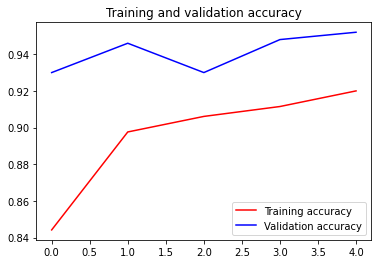

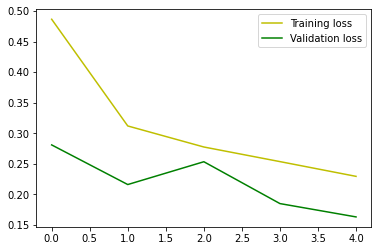

In [36]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.legend(loc=1)

plt.show()